In the previous linear programming approach, we noticed that those who signed up first did not necessarily have higher satisfaction scores. While this is not a requirement for a linear programming solution, we do want to prioritize those who signed up first, which we can do by modifying the objective function. The majority of this notebook will be the same as SeatingLP.ipynb.

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
os.listdir()

['SampleSimpleFinal.xlsx',
 'SampleLPFinal.xlsx',
 'SeatingLP.ipynb',
 'LPformulation',
 '.DS_Store',
 'README.md',
 'SampleCompanies.csv',
 '.ipynb_checkpoints',
 'SimpleSeating.ipynb',
 '.git',
 'SampleLPPriorityFinal.xlsx',
 'SampleStudents.csv',
 'SeatingLPWithPriority.ipynb']

### Import data

In [3]:
companies_df = pd.read_csv('SampleCompanies.csv')

In [4]:
companies_df

,Company,Maximum load
0,Company A,6
1,Company B,12
2,Company C,6
3,Company D,6
4,Company E,6
5,Company F,7
6,Company G,6


In [5]:
students_df = pd.read_csv('SampleStudents.csv')

In [6]:
students_df.head()

,What is your name?,#1 Interest,#2 Interest,#3 Interest,#4 Interest,#5 Interest,#6 Interest,#7 Interest
0,Jamie Obrien,Company A,Company B,Company C,Company D,Company E,Company F,Company G
1,Gilberto Ortega,Company G,Company D,Company C,Company B,Company A,Company E,Company F
2,Anne Tyler,Company B,Company E,Company G,Company A,Company F,Company D,Company C
3,Marshall Underwood,Company G,Company B,Company C,Company E,Company A,Company F,Company D
4,Nicholas Howard,Company E,Company D,Company F,Company B,Company A,Company C,Company G


### Specify number of rotations to event

In [7]:
rotations = 3

### Seat students

Before with the iterative seating method, we simply had a maximum capacity for each company table (per rotation). In this case, I will define a minimum as well since we can formulate it as a linear constraint later on. We'll say that the minimum is 0.75 of the max load, rounded up.

In [8]:
# Extract dataframe info into a dict
student_preferences = {}
student_mapping = {}
students = 0
for row in students_df.itertuples():
    student_preferences[row[1]] = list(row[2:])
    student_mapping[students] = row[1]
    students += 1
    
# Extract company info into a dict
company_capacity = {}
company_mapping = {}
companies = 0
for row in companies_df.itertuples():
    company_capacity[row[1]] = {"max" : row[2], "min" : np.ceil(0.75 * row[2])}
    company_mapping[companies] = row[1]
    companies += 1 

In [9]:
# copy original dictionary
import copy
student_preferences_orig = copy.deepcopy(student_preferences)

In [10]:
company_capacity

{'Company A': {'max': 6, 'min': 5.0},
 'Company B': {'max': 12, 'min': 9.0},
 'Company C': {'max': 6, 'min': 5.0},
 'Company D': {'max': 6, 'min': 5.0},
 'Company E': {'max': 6, 'min': 5.0},
 'Company F': {'max': 7, 'min': 6.0},
 'Company G': {'max': 6, 'min': 5.0}}

### Linear Programming

Technically what we desire is an integer programming problem, since we either have a student sit with a company for a given rotation, or not - these can be represented by 0s and 1s. We can specify our variables as LpIntegers.

In [11]:
from pulp import *

In [12]:
# create LP problem
seating_problem = LpProblem('seating', LpMaximize)

In [13]:
# initialize LP variables
names = ["_{}_{}_{}".format(s, c, r) for r in range(rotations) for c in range(companies) for s in range(students)]
var_dict = LpVariable.dict("x", names, 0, 1, LpInteger)

For our LP problem, we define $x_{s, c, r} = 1$ if student $s$ sits with company $c$ at rotation $r$, and 0 otherwise. We then write the linear program as follows: <br>

$max$ satisfaction <br>
$s.t.$ <br> 
(1) $\sum_{c=1}^{C} x_{s,c,r} = 1$ $\forall s,r$ <br>
(2) $\sum_{r=1}^{R} x_{s,c,r} = R$ $\forall s$ <br>
(3) $\sum_{s=1}^{S} x_{s,c,r} \leq nmax_{c}$ $\forall c, r$ <br>
(4) $\sum_{s=1}^{S} x_{s,c,r} \geq nmin_{c}$ $\forall c, r$ <br>
(5) $\sum_{r=1}^{R} x_{s,c,r} \leq 1$ $\forall s, c$ <br>

In simpler terms:
(1) Each student should be seated with one company per rotation.
(2) Each student should be seated with a total of R companies, where R is the number of rotations.
(3) At each rotation, each company should not exceed their maximum seating capacity.
(4) At each rotation, each company should seat at least their minimum seating capacity.
(5) Each student should not be seated with a company more than once.

In [14]:
# constraint 1
for r in range(rotations):
    for s in range(students):
        con1 = sum([var_dict["_{}_{}_{}".format(s, c, r)] for c in range(companies)]) == 1
        seating_problem += con1
        
# constraint 2
for s in range(students):
    con2 = sum([var_dict["_{}_{}_{}".format(s, c, r)] for c in range(companies) for r in range(rotations)]) == rotations
    seating_problem += con2
    
# constraint 3
for r in range(rotations):
    for c in range(companies):
        con3 = sum([var_dict["_{}_{}_{}".format(s, c, r)] for s in range(students)]) <= company_capacity[company_mapping[c]]['max']
        seating_problem += con3
        
# constraint 4
for r in range(rotations):
    for c in range(companies):
        con4 = sum([var_dict["_{}_{}_{}".format(s, c, r)] for s in range(students)]) >= company_capacity[company_mapping[c]]['min']
        seating_problem += con4
        
# constraint 5
for s in range(students):
    for c in range(companies):
        con5 = sum([var_dict["_{}_{}_{}".format(s, c, r)] for r in range(rotations)]) <= 1
        seating_problem += con5

Next we must specify the objective function using constants. We start by defining scores for each student and company pairing (based on their preference list). To modify the objective function for each student, we will modify the scores that we determine for the student-company pairings by multiplying the original score by some value dependent on the ordering of responses.

For example, let's assume seating student $s$ with company $c$ would give $5$ points in the usual scenario. We will multiply this value by $\frac{n_{tot}-0.85n_s}{n_{tot}}$, where $n_{tot}$ is the total number of responses and student $s$ has the $n_s$th response. We can see that if $n_s$ is smaller (earlier response), we will weigh the scores more.

In [15]:
scores = {}
obj_scores = {}
for s in range(students):
    for c in range(companies):
        try:
            scores["_{}_{}".format(s, c)] = companies - student_preferences[student_mapping[s]].index(company_mapping[c])
            obj_scores["_{}_{}".format(s, c)] = (companies - student_preferences[student_mapping[s]].index(company_mapping[c])) * (students - 0.8*s)/students
        except:
            scores["_{}_{}".format(s, c)] = 0
            obj_scores["_{}_{}".format(s, c)] = 0
            print(student_mapping[s], " is missing companies in preference list")
            print(student_preferences[student_mapping[s]])

Phyllis Roberts  is missing companies in preference list
['Company B', 'Company E', 'Company F', 'Company C', 'Company D', 'Company D', 'Company A']
Amber Adkins  is missing companies in preference list
['Company B', 'Company G', 'Company E', 'Company D', 'Company C', 'Company G', 'Company F']
Jay Edwards  is missing companies in preference list
['Company D', 'Company E', 'Company B', 'Company G', 'Company A', 'Company F', 'Company G']


In [16]:
# Objective function
obj = sum([obj_scores["_{}_{}".format(s, c)] * var_dict["_{}_{}_{}".format(s, c, r)]  for s in range(students) for c in range(companies) for r in range(rotations)])
seating_problem += obj

In [17]:
# Write linear program to text file
seating_problem.writeLP("LPformulation")

In [18]:
# Solve
LpSolverDefault.msg = 1
seating_problem.solve()
# print(LpStatus[status])

1

In [19]:
# Evaluating performance
print("Objective value:", value(seating_problem.objective))
print ('\nThe values of the variables : \n')
for v in seating_problem.variables():
        print(v.name, "=", v.varValue)

Objective value: 525.1795918367347

The values of the variables : 

x__0_0_0 = 0.0
x__0_0_1 = 1.0
x__0_0_2 = 0.0
x__0_1_0 = 1.0
x__0_1_1 = 0.0
x__0_1_2 = 0.0
x__0_2_0 = 0.0
x__0_2_1 = 0.0
x__0_2_2 = 0.0
x__0_3_0 = 0.0
x__0_3_1 = 0.0
x__0_3_2 = 1.0
x__0_4_0 = 0.0
x__0_4_1 = 0.0
x__0_4_2 = 0.0
x__0_5_0 = 0.0
x__0_5_1 = 0.0
x__0_5_2 = 0.0
x__0_6_0 = 0.0
x__0_6_1 = 0.0
x__0_6_2 = 0.0
x__10_0_0 = 0.0
x__10_0_1 = 0.0
x__10_0_2 = 0.0
x__10_1_0 = 0.0
x__10_1_1 = 0.0
x__10_1_2 = 0.0
x__10_2_0 = 0.0
x__10_2_1 = 1.0
x__10_2_2 = 0.0
x__10_3_0 = 0.0
x__10_3_1 = 0.0
x__10_3_2 = 0.0
x__10_4_0 = 0.0
x__10_4_1 = 0.0
x__10_4_2 = 0.0
x__10_5_0 = 0.0
x__10_5_1 = 0.0
x__10_5_2 = 1.0
x__10_6_0 = 1.0
x__10_6_1 = 0.0
x__10_6_2 = 0.0
x__11_0_0 = 0.0
x__11_0_1 = 1.0
x__11_0_2 = 0.0
x__11_1_0 = 0.0
x__11_1_1 = 0.0
x__11_1_2 = 0.0
x__11_2_0 = 0.0
x__11_2_1 = 0.0
x__11_2_2 = 0.0
x__11_3_0 = 0.0
x__11_3_1 = 0.0
x__11_3_2 = 0.0
x__11_4_0 = 0.0
x__11_4_1 = 0.0
x__11_4_2 = 0.0
x__11_5_0 = 1.0
x__11_5_1 = 0.0
x__11_5_2

x__36_3_2 = 1.0
x__36_4_0 = 1.0
x__36_4_1 = 0.0
x__36_4_2 = 0.0
x__36_5_0 = 0.0
x__36_5_1 = 0.0
x__36_5_2 = 0.0
x__36_6_0 = 0.0
x__36_6_1 = 1.0
x__36_6_2 = 0.0
x__37_0_0 = 0.0
x__37_0_1 = 0.0
x__37_0_2 = 0.0
x__37_1_0 = 0.0
x__37_1_1 = 0.0
x__37_1_2 = 1.0
x__37_2_0 = 0.0
x__37_2_1 = 0.0
x__37_2_2 = 0.0
x__37_3_0 = 0.0
x__37_3_1 = 0.0
x__37_3_2 = 0.0
x__37_4_0 = 1.0
x__37_4_1 = 0.0
x__37_4_2 = 0.0
x__37_5_0 = 0.0
x__37_5_1 = 0.0
x__37_5_2 = 0.0
x__37_6_0 = 0.0
x__37_6_1 = 1.0
x__37_6_2 = 0.0
x__38_0_0 = 0.0
x__38_0_1 = 0.0
x__38_0_2 = 0.0
x__38_1_0 = 0.0
x__38_1_1 = 0.0
x__38_1_2 = 0.0
x__38_2_0 = 0.0
x__38_2_1 = 0.0
x__38_2_2 = 0.0
x__38_3_0 = 0.0
x__38_3_1 = 1.0
x__38_3_2 = 0.0
x__38_4_0 = 0.0
x__38_4_1 = 0.0
x__38_4_2 = 1.0
x__38_5_0 = 0.0
x__38_5_1 = 0.0
x__38_5_2 = 0.0
x__38_6_0 = 1.0
x__38_6_1 = 0.0
x__38_6_2 = 0.0
x__39_0_0 = 0.0
x__39_0_1 = 0.0
x__39_0_2 = 0.0
x__39_1_0 = 1.0
x__39_1_1 = 0.0
x__39_1_2 = 0.0
x__39_2_0 = 0.0
x__39_2_1 = 0.0
x__39_2_2 = 1.0
x__39_3_0 = 0.0
x__39_3_

### Extracting seating information

In [20]:
# store lists of who is sitting where at each rotation
student_seating = {student: {} for student in student_preferences}
company_seating = {company: {} for company in company_capacity}
for s in range(students):
    # get name of student
    student = student_mapping[s]
    student_seating[student]['satisfaction'] = 0
    for c in range(companies):
        # get name of company
        company = company_mapping[c]
        for r in range(rotations):
            rotation_name = 'rotation' + str(r + 1)
            # if company currently does not have a list of students for the rotation, add it
            if not company_seating[company].get(rotation_name):
                company_seating[company][rotation_name] = []
            # if there is still space at the table for this rotation
            # if student s sits with company c at rotation r
            if value(var_dict['_{}_{}_{}'.format(s, c, r)]) == 1:
                student_seating[student][rotation_name] = company
                company_seating[company][rotation_name].append(student)
            # if they are not assigned together
            else:
                # if we currently don't have an entry for the rotation
                if rotation_name not in student_seating[student]:
                    student_seating[student][rotation_name] = ''
            # add to satisfaction score
            student_seating[student]['satisfaction'] += scores["_{}_{}".format(s, c)] * value(var_dict["_{}_{}_{}".format(s, c, r)])
    # normalize score
    student_seating[student]['satisfaction'] /= sum([companies - i for i in range(rotations)])

In [21]:
student_seating_df = pd.DataFrame.from_dict(data=student_seating, orient='index')

In [22]:
company_seating_df = pd.DataFrame.from_dict(data=company_seating, orient='index')

### Export to Excel

In [24]:
# write to excel
from pandas import ExcelWriter

In [25]:
def save_xls(list_dfs, xls_path, sheet_names):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer, sheet_names[n])
        writer.save()

In [26]:
list_dfs = [student_seating_df, company_seating_df]
xls_path = "SampleLPPriorityFinal.xlsx"
sheet_names = ['Student Seating', 'Company Seating']

In [27]:
save_xls(list_dfs, xls_path, sheet_names)

### Analysis

In [28]:
satisfaction_values = student_seating_df['satisfaction'].values
print('Average satisfaction: ', np.mean(satisfaction_values))
print('Min satisfaction: ', np.min(satisfaction_values))
print('Max satisfaction: ', np.max(satisfaction_values))
print('MinMax difference: ', np.max(satisfaction_values) - np.min(satisfaction_values))

Average satisfaction:  0.9625850340136054
Min satisfaction:  0.6111111111111112
Max satisfaction:  1.0
MinMax difference:  0.38888888888888884


In [29]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Count')

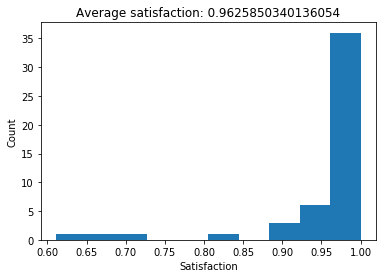

In [30]:
fig, ax = plt.subplots(1, 1)
ax.hist(student_seating_df['satisfaction']);
ax.set_title('Average satisfaction: {}'.format(np.mean(satisfaction_values)))
ax.set_xlabel('Satisfaction')
ax.set_ylabel('Count')

The distribution is slightly more skewed than the previous linear programming approach, because we prioritize earlier responses. In general, that c